In [2]:
import pandas as pd
import numpy as np
import gcnIO
import os

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import average_precision_score, precision_recall_curve
from scipy import interp

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
model_dir = '../data/GCN/training/2018_08_10_11_28_41/'

args, data_file = gcnIO.load_hyper_params(model_dir)
data = gcnIO.load_hdf_data(data_file)
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names = data
print ("Data comes from {}".format(data_file))
print (args)
CLASSIFICATION_THRESHOLD = 0.5


Hyper-Parameters read from ../data/GCN/training/2018_08_10_11_28_41/hyper_params.txt
Data comes from ../data/pancancer/iref_multiomics_norm_tcgage_methpromonly1000bp.h5
{'data': '../data/pancancer/iref_multiomics_norm_tcgage_methpromonly1000bp.h5', 'support': 2, 'epochs': 1000, 'dropout': 0.25, 'lr': 0.001, 'decay': 0.0005, 'hidden_dims': [50, 40, 30, 20, 10], 'cv_runs': 2, 'loss_mul': 250.0}


## Read Predictions

In [4]:
pred_all = []
sets_all = []
no_cv = 0
for cv_dir in os.listdir(model_dir):
    if cv_dir.startswith('cv_'):
        predictions = pd.DataFrame.from_csv(os.path.join(model_dir, cv_dir, 'predictions.tsv'), sep='\t', header=0)
        pred_all.append(predictions)
        y_train, y_test, train_mask, test_mask = gcnIO.read_train_test_sets(os.path.join(model_dir, cv_dir))
        sets_all.append((y_train, y_test, train_mask, test_mask))
        no_cv += 1
print ("Read predictions from {} CV runs".format(no_cv))

Read predictions from 2 CV runs


## Average ROC Curve

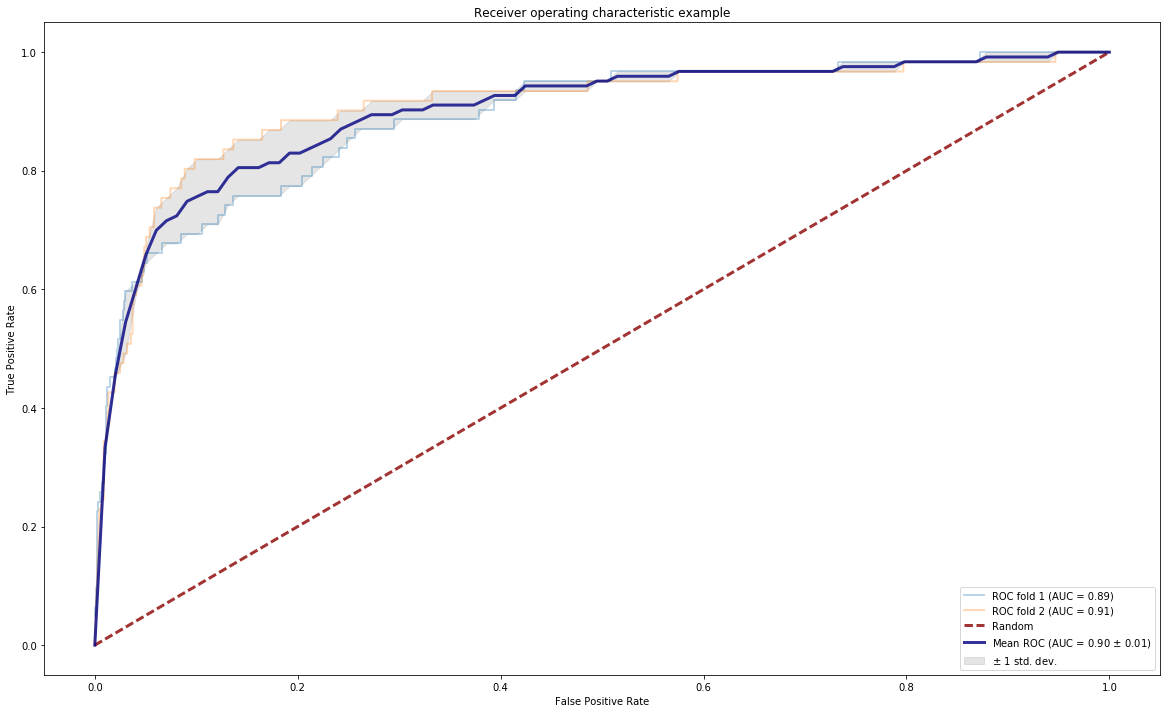

In [7]:
# construct test set statistics
fig = plt.figure(figsize=(20, 12))

k = 1
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for pred in pred_all:
    y_t = sets_all[k-1][1]
    m_t = sets_all[k-1][3]
    fpr, tpr, _ = roc_curve(y_score=pred[m_t].Prob_pos, y_true=y_t[m_t])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    auroc = roc_auc_score(y_score=pred[m_t].Prob_pos, y_true=y_t[m_t])
    aucs.append(auroc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (k, auroc))
    k += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='darkred',
         label='Random', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='navy',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=3, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Average PR Curve

3


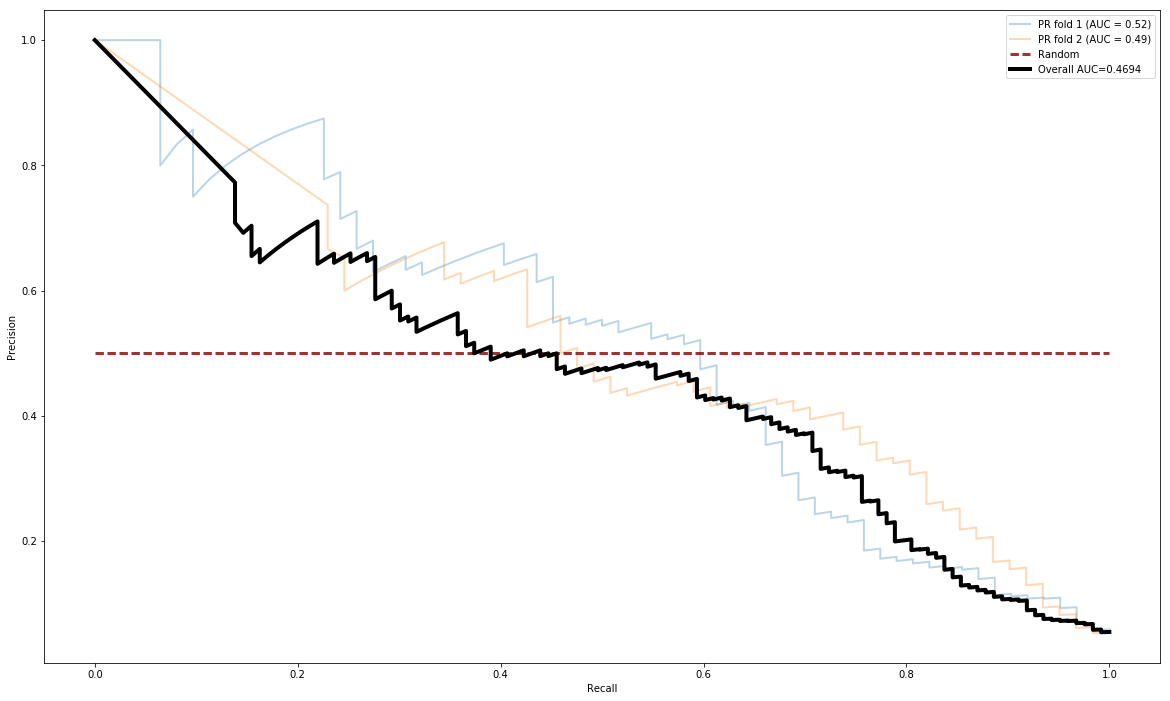

In [6]:
fig = plt.figure(figsize=(20, 12))

k = 1
y_true = []
y_pred = []
for pred in pred_all:
    y_t = sets_all[k-1][1]
    m_t = sets_all[k-1][3]
    pr, rec, _ = precision_recall_curve(probas_pred=pred[m_t].Prob_pos, y_true=y_t[m_t])
    aupr = average_precision_score(y_score=pred[m_t].Prob_pos, y_true=y_t[m_t])
    plt.plot(rec, pr, lw=2, alpha=0.3, label='PR fold %d (AUC = %0.2f)' % (k, aupr))
    y_true.append(y_t[m_t])
    y_pred.append(pred[m_t].Prob_pos)
    k += 1
print (k)
plt.plot([0, 1], [1/(k-1), 1/(k-1)], linestyle='--', lw=3, color='darkred',
         label='Random', alpha=.8)
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
precision, recall, _ = precision_recall_curve(y_true, y_pred)
label = 'Overall AUC=%.4f' % (auc(recall, precision))
plt.plot(recall, precision, label=label, lw=4, color='black')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')